[*********************100%%**********************]  1 of 1 completed
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3827222099.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price=financial_data['Adj Close'][k]
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3827222099.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  signals['orders'][k]=1
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3827222099.py:43: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a valu

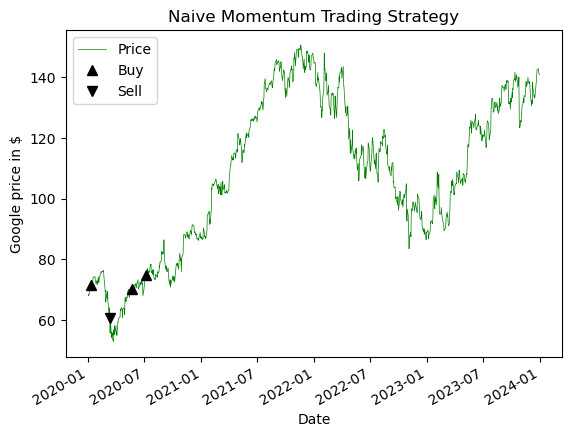

In [4]:
'''모멘텀 기본 전략
1. 가격이 개선된 횟수를 계산
2. 숫자가 주어진 임계값과 같으면 가격이 계속 상승한다고 가정
3. 가격이 계속 하락할 것이라고 가정하면 매도'''
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


def load_financial_data(start_date, end_date):
    df = yf.download('GOOG', start_date, end_date)
    return df

goog_data=load_financial_data(start_date='2020-01-01',
                    end_date = '2024-01-01')




def naive_momentum_trading(financial_data, nb_conseq_days):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    cons_day=0
    prior_price=0
    init=True
    for k in range(len(financial_data['Adj Close'])):
        price=financial_data['Adj Close'][k]
        if init:
            prior_price=price
            init=False
        elif price>prior_price:
            if cons_day<0:
                cons_day=0
            cons_day+=1
        elif price<prior_price:
            if cons_day>0:
                cons_day=0
            cons_day-=1
        if cons_day==nb_conseq_days:
            signals['orders'][k]=1
        elif cons_day == -nb_conseq_days:
            signals['orders'][k]=-1


    return signals


ts=naive_momentum_trading(goog_data, 5)

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1],
         'v', markersize=7, color='k')

plt.legend(["Price","Buy","Sell"])
plt.title("Naive Momentum Trading Strategy")

plt.show()



위의 전략은 초보적 트레이딩 전략이기 때문에
많은 주문을 생성하지 않고 있다.

[*********************100%%**********************]  1 of 1 completed
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signals['long_entry'][k] and position==0:
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif signals['short_entry'][k] and position==0:
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

            orders        high         low         avg  long_entry  \
Date                                                                 
2020-01-02       0         NaN         NaN         NaN       False   
2020-01-03       0         NaN         NaN         NaN       False   
2020-01-06       0         NaN         NaN         NaN       False   
2020-01-07       0         NaN         NaN         NaN       False   
2020-01-08       0         NaN         NaN         NaN       False   
...            ...         ...         ...         ...         ...   
2023-12-22      -1  141.800003  130.630005  135.708500        True   
2023-12-26       1  142.720001  130.630005  135.933500        True   
2023-12-27      -1  142.820007  130.630005  136.172000       False   
2023-12-28       0  142.820007  130.630005  136.313000       False   
2023-12-29       0  142.820007  130.630005  136.557001       False   

            short_entry  long_exit  short_exit  
Date                                    

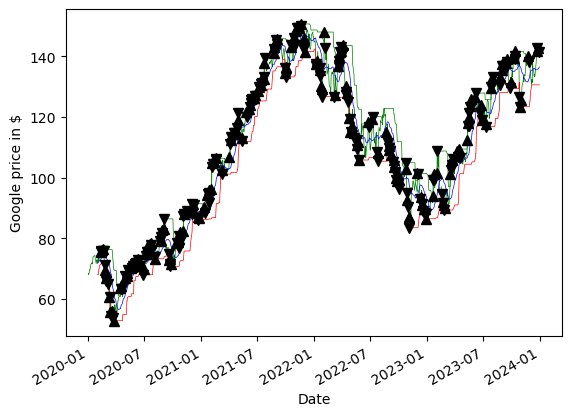

In [41]:
#터틀 전략
#마지막 windw_size일 동안 최고 가격에 도달하면 롱 시그널을 만들 것

def load_financial_data(ticker,start_date, end_date):
    df = yf.download(ticker, start_date, end_date)
    return df

goog_data=load_financial_data('GOOG',start_date='2020-01-01',
                    end_date = '2024-01-01')

def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    # 고가에 대한 윈도우 크기
    signals['high'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).max()
    # 저가에 대한 윈도우 크기
    signals['low'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).min()
    # 평균에 대한 윈도우 크기
    signals['avg'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).mean()

    # 주문 규칙 : stock price > the higest value for window_size day
    #              stock price < the lowest value for window_size day

    signals['long_entry'] = financial_data['Adj Close'] > signals.high
    signals['short_entry'] = financial_data['Adj Close'] < signals.low

    #청산 규칙 : 주가가 과거 window size 일의 평균을 교차할 때.

    signals['long_exit'] = financial_data['Adj Close'] < signals.avg
    signals['short_exit'] = financial_data['Adj Close'] > signals.avg
    # 롱 포지션 1, 숏포지션 -1, 아무것도 변경 x 0
    init=True
    position=0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position=1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position=-1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals

ts=turtle_trading(goog_data, 20)
print(ts)

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)


ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')
'''


ax1.plot(ts.loc[ts.long_entry== True].index,
         goog_data["Adj Close"][ts.long_entry== True],
          '^', markersize=2, color='r')

ax1.plot(ts.loc[ts.short_entry== True].index,
          goog_data["Adj Close"][ts.short_entry== True],
          'v', markersize=2, color='g')

ax1.plot(ts.loc[ts.long_exit == True].index,
          goog_data["Adj Close"][ts.long_exit == True],
          'v', markersize=1, color='b')

ax1.plot(ts.loc[ts.short_exit == True].index,
          goog_data["Adj Close"][ts.short_exit == True],
          'v', markersize=1, color='k')


plt.legend(["Price","Highs","Lows","Average","Buy","Sell"])
plt.title("Turtle Trading Strategy")

plt.show()
'''


def backtest_turtle_trading(ticker, start_date, end_date, window_size=50, initial_capital=10000.0):
    financial_data = load_financial_data(ticker, start_date, end_date)
    signals = turtle_trading(financial_data, window_size)

    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions[ticker] = 100 * signals['orders']

    portfolio = positions.multiply(financial_data['Adj Close'], axis=0)
    portfolio['prices']=financial_data['Adj Close']
    portfolio['holdings'] = (positions.multiply(financial_data['Adj Close'], axis=0)).sum(axis=1)
    
    pos_diff = positions.diff()
    portfolio['cash'] = initial_capital - (pos_diff.multiply(financial_data['Adj Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    print(portfolio)
    # 거래 로그 생성
    trade_log = pd.DataFrame(columns=['Date', 'Order', 'Price', 'Position'])
    position = 0
    for k in range(len(signals)):
        if signals['orders'][k] != 0:
            order = 'Buy' if signals['orders'][k] == 1 else 'Sell'
            price = financial_data['Adj Close'][k]
            new_log = pd.DataFrame({'Date': [signals.index[k]], 'Order': [order], 'Price': [price], 'Position': [position]})
            trade_log = pd.concat([trade_log, new_log], ignore_index=True)
            position += signals['orders'][k] * 10

    print(trade_log)

    fig = plt.figure()
    ax1 = fig.add_subplot(111, ylabel=f'{ticker} price in $')
    financial_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
    signals["high"].plot(ax=ax1, color='g', lw=.5)
    signals["low"].plot(ax=ax1, color='r', lw=.5)
    signals["avg"].plot(ax=ax1, color='b', lw=.5)

    ax1.plot(signals.loc[signals.long_entry == True].index,
             financial_data["Adj Close"][signals.long_entry == True],
             '^', markersize=2, color='r')
    
    ax1.plot(signals.loc[signals.short_entry == True].index,
             financial_data["Adj Close"][signals.short_entry == True],
             'v', markersize=2, color='g')
    
    ax1.plot(signals.loc[signals.long_exit == True].index,
             financial_data["Adj Close"][signals.long_exit == True],
             'v', markersize=1, color='b')
    
    ax1.plot(signals.loc[signals.short_exit == True].index,
             financial_data["Adj Close"][signals.short_exit == True],
             'v', markersize=1, color='k')

    plt.legend(["Price", "Highs", "Lows", "Average", "Buy", "Sell"])
    plt.title(f"Turtle Trading Strategy for {ticker}")

    plt.show()


[*********************100%%**********************]  1 of 1 completed
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signals['long_entry'][k] and position==0:
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif signals['short_entry'][k] and position==0:
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

            GOOG     prices  holdings         cash        total  returns
Date                                                                    
2004-08-19   0.0   2.499133       0.0  10000.00000  10000.00000      NaN
2004-08-20   0.0   2.697639       0.0  10000.00000  10000.00000      0.0
2004-08-23   0.0   2.724787       0.0  10000.00000  10000.00000      0.0
2004-08-24   0.0   2.611960       0.0  10000.00000  10000.00000      0.0
2004-08-25   0.0   2.640104       0.0  10000.00000  10000.00000      0.0
...          ...        ...       ...          ...          ...      ...
2017-12-22   0.0  53.006001       0.0  10859.48658  10859.48658      0.0
2017-12-26   0.0  52.837002       0.0  10859.48658  10859.48658      0.0
2017-12-27   0.0  52.468498       0.0  10859.48658  10859.48658      0.0
2017-12-28   0.0  52.407001       0.0  10859.48658  10859.48658      0.0
2017-12-29   0.0  52.320000       0.0  10859.48658  10859.48658      0.0

[3366 rows x 6 columns]


C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signals['orders'][k] != 0:
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  order = 'Buy' if signals['orders'][k] == 1 else 'Sell'
C:\Users\comma\AppData\Local\Temp\ipykernel_11616\3718250617.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price 

          Date Order      Price Position
0   2004-11-01   Buy   4.882449        0
1   2004-11-02  Sell   4.853558       10
2   2004-12-30   Buy   4.921553        0
3   2004-12-31  Sell   4.801752       10
4   2005-01-03   Buy   5.048826        0
..         ...   ...        ...      ...
705 2017-11-08  Sell  51.992500       10
706 2017-11-24   Buy  52.030499        0
707 2017-11-27  Sell  52.710499       10
708 2017-12-15   Buy  53.209499        0
709 2017-12-18  Sell  53.856998       10

[710 rows x 4 columns]


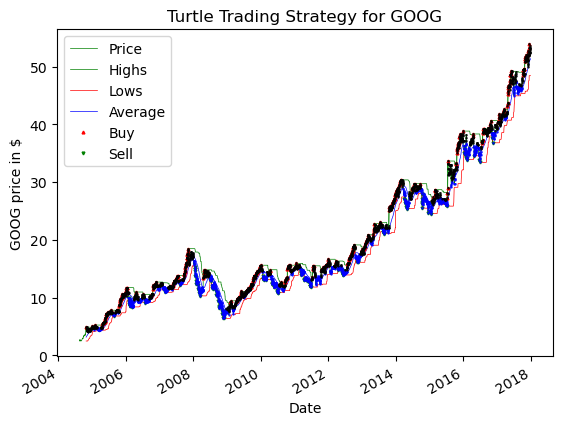

In [42]:

# 사용 예시
backtest_turtle_trading('GOOG', '2001-01-01', '2018-01-01', window_size=50, initial_capital=10000.0)